# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
from tqdm.auto import tqdm

%matplotlib inline

## Reading input data

In [7]:
QAP_INSTANCE_URL = 'https://www.opt.math.tugraz.at/qaplib/data.d/nug12.dat'
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])


A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))


B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))


print('Problem size: %d' % n)
print('Flow matrix:\n', A)
print('Distance matrix:\n', B)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [10]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [7]:
# p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
# print(qap_objective_function(p), p)

## Random Sampling

In [15]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

42.2057363986969
592.0 [ 1  9  5  4  2  6 10  8  0  7  3 11]


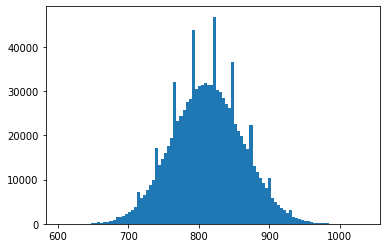

812.057492 49.73411415386761


In [9]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs)

print(costs.mean(), costs.std())

## Simulated Annealing

In [13]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [21]:
def simulated_annealing(T, radius, alpha):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min(), costs.argmin())

    return costs

In [13]:
T = 500000
radius = 1
alpha = 1.0

# simulated_annealing(T, radius, alpha)

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min(), costs.argmin())

27.906429767608643 578.0 42970


[800. 786. 798. ... 578. 578. 578.]


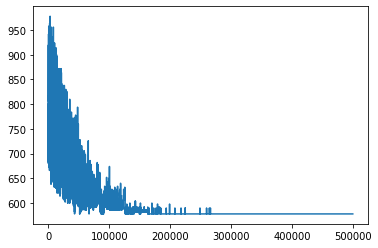

In [14]:
print(costs)

plt.figure()
plt.plot(costs)
plt.show()

## 1a

T, radius, alpha: time, costs.min costs.argmin

### N14:
* 500000, 1, 1.0:  31.978957414627075 1014.0

### N18
* 500000, 1, 1.0: 39.154966592788696 1930.0
* 500000, 1, 0.5: 39.064759731292725 1944.0

In [22]:
# 1b
T = 500000
radius = 1
alpha = 1.0

k = 10

costs = []

for i in range(1,k):
    costs.append(simulated_annealing(T, radius, alpha))
    # costs += simulated_annealing(T, radius, alpha)

costs


27.814016103744507 578.0 46201
27.77352285385132 578.0 38725
27.681220769882202 578.0 49589
27.589390516281128 578.0 41444
27.507948398590088 578.0 58896
27.56494379043579 578.0 55480
27.62261652946472 578.0 53399
27.557711124420166 578.0 38548
27.51066279411316 578.0 40548


[array([806., 794., 816., ..., 578., 578., 578.]),
 array([754., 766., 734., ..., 586., 586., 586.]),
 array([814., 782., 840., ..., 586., 586., 586.]),
 array([816., 798., 800., ..., 600., 600., 600.]),
 array([876., 806., 870., ..., 578., 578., 578.]),
 array([838., 832., 838., ..., 582., 582., 582.]),
 array([768., 788., 828., ..., 586., 586., 586.]),
 array([864., 868., 832., ..., 586., 586., 586.]),
 array([780., 820., 786., ..., 586., 586., 586.])]

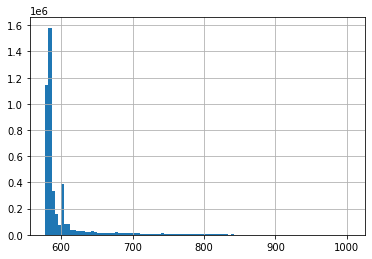

601.915172 43.88128617315602


In [24]:
costs2 = np.concatenate(costs)


plt.figure()
plt.axis(True)
plt.grid(True)
plt.hist(costs2,bins=100)
plt.show()

print(costs2.mean(), costs2.std())

In [14]:
def simulated_annealing_2(T, radius, alpha):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)

    succeses = 0
    acc_fails = 0

    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            succeses += 1
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            acc_fails += 1
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min(), costs.argmin())



    return (succeses, acc_fails)

In [15]:
x = map((lambda x: x[0]), [(1,2), (3,4)])
list(x)

[1, 3]

In [16]:
import matplotlib.pyplot as plt
T = 500000
# radius = 1
# alpha = 1.0


inputs = [(1, 1.0), (2, 1.0), (3, 1.0), (1, 0.5), (1, 1.5), (1, 2.0), (1, 2.5), (2, 2.0), (2, 2.5), (3, 3.0)]

labels = map(str, inputs)

outputs = list(map((lambda x: simulated_annealing_2(T, x[0], x[1])), inputs))



27.698051929473877 578.0 54099
32.678197145462036 578.0 92590
37.032097816467285 578.0 53620
27.596624851226807 578.0 102148
27.57080578804016 578.0 30130
27.694801092147827 578.0 19609
27.694265365600586 586.0 21389
32.44162607192993 588.0 17323
32.368515729904175 586.0 18373
37.087008476257324 586.0 81275


In [17]:
outputs

[(12844, 14413),
 (8240, 16469),
 (7405, 7878),
 (25315, 29331),
 (8227, 9227),
 (6270, 7146),
 (5192, 6539),
 (4269, 12136),
 (3349, 11250),
 (2530, 2669)]

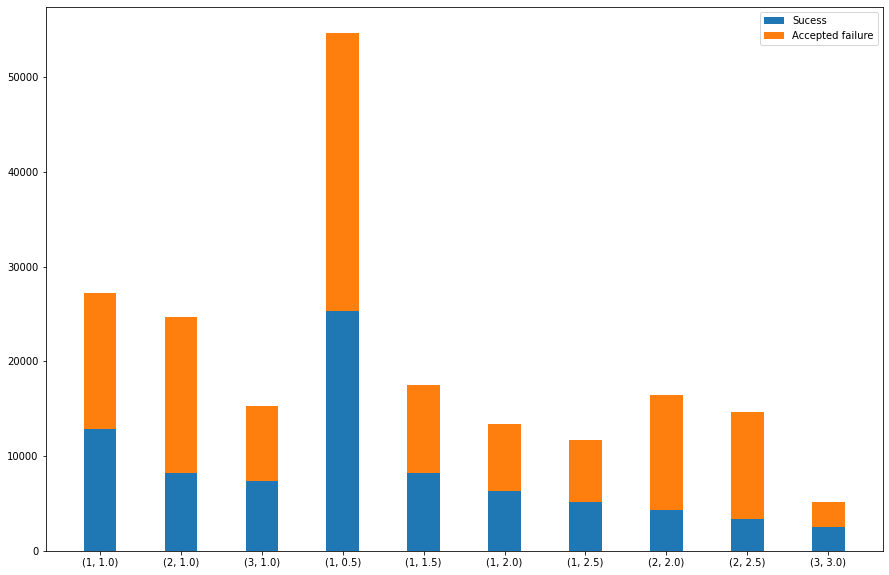

In [18]:
succ = list(map((lambda x: x[0]), outputs))
acc_fail = list(map((lambda x: x[1]), outputs))
labels = list(labels)
width = 0.4

fig, ax = plt.subplots()

fig.set_size_inches(15, 10, forward=True)
ax.bar(labels, succ, width, label='Sucess')
ax.bar(labels, acc_fail, width, bottom=succ,
       label='Accepted failure')

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

In [15]:
# 1d
# Odległość Hamminga - liczba pozycji na której ciągi się różnią

def hamming_distance(p, q):
    return sum(map((lambda x: x!=0), p-q))

def permutation_distance(p, q):
    return min([hamming_distance(np.roll(p, k), q) for k in range(len(p))])



In [4]:
def simulated_annealing_3(T, radius, alpha):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)

    succeses = 0
    acc_fails = 0
    
    # res = []
    cost_diffs = []
    distances = []

    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            succeses += 1
            cost_diffs.append(p_cost - q_cost)
            distances.append(permutation_distance(p, q))
            p, p_cost = q, q_cost
            # res.append((p_cost - q_cost, permutation_distance(p, q)))
            

        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            acc_fails += 1
            p, p_cost = q, q_cost
        costs[t] = p_cost

    # print(time.time() - t0, costs.min(), costs.argmin())

    # print(cost_diffs, distances)



    return (cost_diffs, distances)

In [17]:
T = 500000
radius = 3
alpha = 1.0


costs_diff = []
dists = []

for i in tqdm(range(1)):
    (c, d) = simulated_annealing_3(T, radius, alpha)
    costs_diff += c
    dists += d




100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


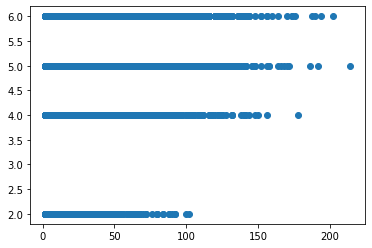

In [18]:

plt.scatter(x=costs_diff, y=dists)
plt.show()